<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter10/model-calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%capture
!pip3 install xgboost==1.6.1 imbalanced-learn==0.9.1 seaborn==0.12.1

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

## Synthetic data set prep:

In [5]:
def make_data(sep):
    X, y = make_classification(
        n_samples=5000,
        n_features=2,
        n_redundant=0,
        n_clusters_per_class=1,
        weights=[0.995],
        class_sep=sep,  # how separate the classes are
        random_state=1,
    )

    # trasform arrays into pandas df and series
    X = pd.DataFrame(X, columns=["feature_1", "feature_2"])
    y = pd.Series(y)

    return X, y

0    4950
1      50
dtype: int64


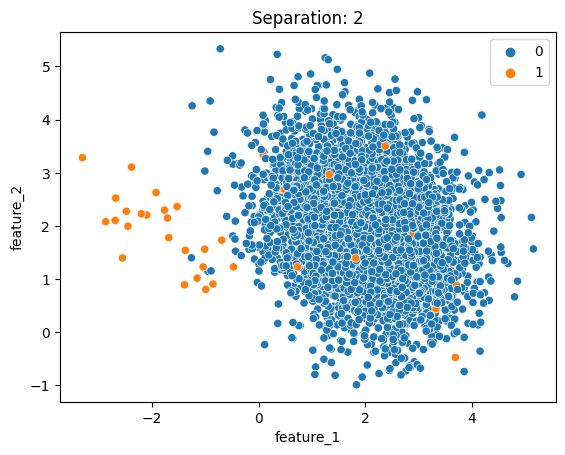

0    4950
1      50
dtype: int64


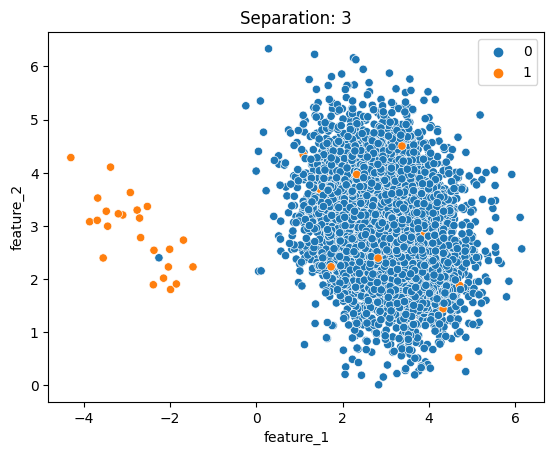

In [6]:
# make datasets with different class separateness
# and plot
synthetic_datasets = []
for sep in [2, 3]:
    X, y = make_data(sep)
    synthetic_datasets.append(
        {
            "data": np.array(X),
            "target": np.array(y),
            "DESCR": "synthetic data, sep: " + str(sep),
        }
    )
    print(y.value_counts())
    sns.scatterplot(data=X, x="feature_1", y="feature_2", hue=y)
    plt.title("Separation: {}".format(sep))
    plt.show()

## Real world data set

In [7]:
# Abalone dataset, and thyroid dataset
from imblearn.datasets import fetch_datasets

# these datasets are baked into imbalanced-learn
dataset_list = ["thyroid_sick", "abalone_19"]

In [8]:
# print class imbalance of each dataset
from collections import Counter
from sklearn.preprocessing import LabelEncoder

all_datasets = []
all_datasets = synthetic_datasets
le = LabelEncoder()
for dataset in dataset_list:
    data = fetch_datasets()[dataset]
    data["target"] = le.fit_transform(data["target"])
    all_datasets.append(data)

for item in all_datasets:
    print(Counter(item["target"]))

Counter({0: 4950, 1: 50})
Counter({0: 4950, 1: 50})
Counter({0: 3541, 1: 231})
Counter({0: 4145, 1: 32})


In [9]:
# function to train random forests and evaluate the performance
from numpy import mean
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    cross_val_predict,
)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

scaler = MinMaxScaler()


def fit_model(classifier, X_train, y_train, undersampler=None):
    model = Pipeline(
        steps=[
            ("minMaxScaling", scaler),
            ("under", undersampler),
            ("model", classifier),
        ]
    )

    model.fit(X_train, y_train)
    return model

# Impact of oversampling techniques on calibration of a model

### Models used: LogisticRegression and XGBoost

In [10]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

oversampler_map = {
    "Nosampling": None,
    "RandomOverSampler": RandomOverSampler(sampling_strategy="auto", random_state=0),
    "SMOTE": SMOTE(random_state=0),
}

In [11]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV


def plot_calibration_curve(run_details, axis, y_true, probs, bins, model):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, probs, n_bins=bins, strategy="quantile"
    )

    max_val = max(mean_predicted_value)

    model_name = type(model.named_steps.model).__name__
    axis.plot(mean_predicted_value, fraction_of_positives, label=model_name)
    axis.plot(
        np.linspace(0, max_val, bins),
        np.linspace(0, max_val, bins),
        linestyle="--",
        color="gray",
        label="Perfect calibration",
    )

    axis.set(xlabel="Probability predictions")
    axis.set(ylabel="Fraction of positives")
    axis.set(title=run_details)
    axis.legend(loc="upper left")

In [12]:
def fit_model_call_plot_calibration_curve(
    sampler_name, sampler, data, model, X_train, X_test, y_train, y_test, axis
):
    run_details = sampler_name + " | Dataset description: " + data["DESCR"]
    model = fit_model(model, X_train, y_train, sampler)
    model_probs = model.predict_proba(X_test)[:, 1]
    plot_calibration_curve(run_details, axis, y_test, model_probs, bins=8, model=model)

In [11]:
# now we train several models, with the different Sampling techniques
def draw_plots(sampler_map):
    for data in all_datasets:
        X_train, X_test, y_train, y_test = train_test_split(
            data["data"],
            data["target"],
            test_size=0.3,
            random_state=0,
        )

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, len(sampler_map)))
        for idx, (sampler_name, sampler) in enumerate(sampler_map.items()):
            lr = LogisticRegression(random_state=0, max_iter=2000)
            fit_model_call_plot_calibration_curve(
                sampler_name,
                sampler,
                data,
                lr,
                X_train,
                X_test,
                y_train,
                y_test,
                axes[idx],
            )
        plt.show()

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, len(sampler_map)))
        for idx, (sampler_name, sampler) in enumerate(sampler_map.items()):
            xgb = XGBClassifier()
            fit_model_call_plot_calibration_curve(
                sampler_name,
                sampler,
                data,
                xgb,
                X_train,
                X_test,
                y_train,
                y_test,
                axes[idx],
            )

        plt.show()

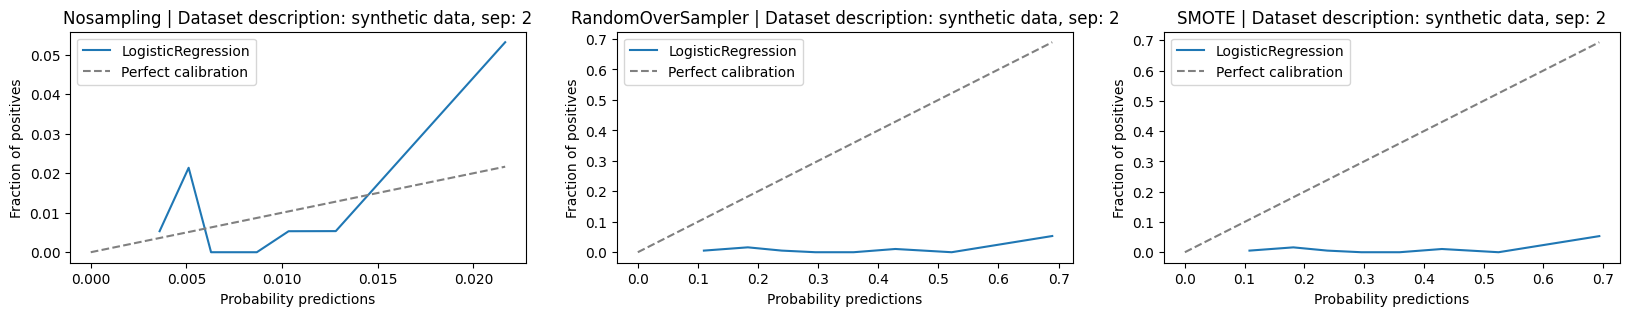

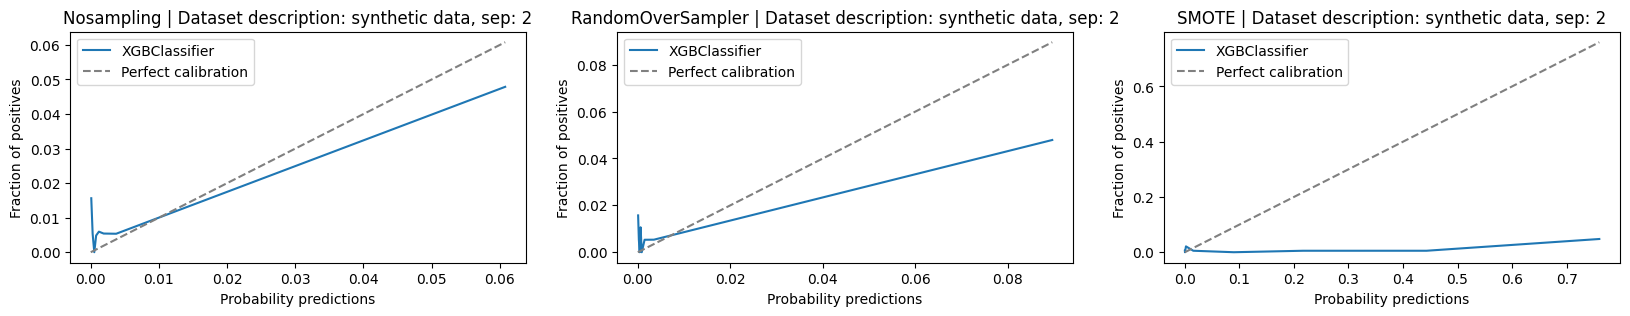

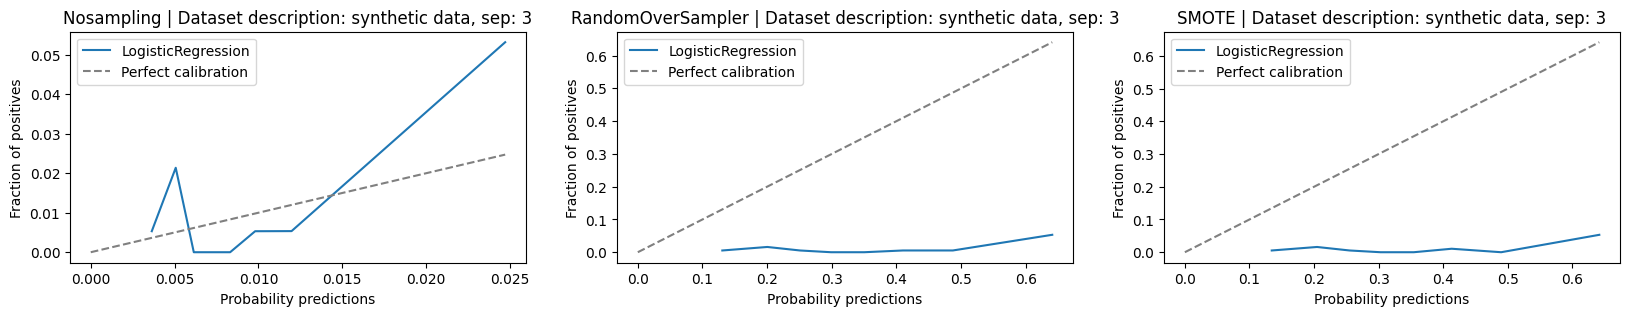

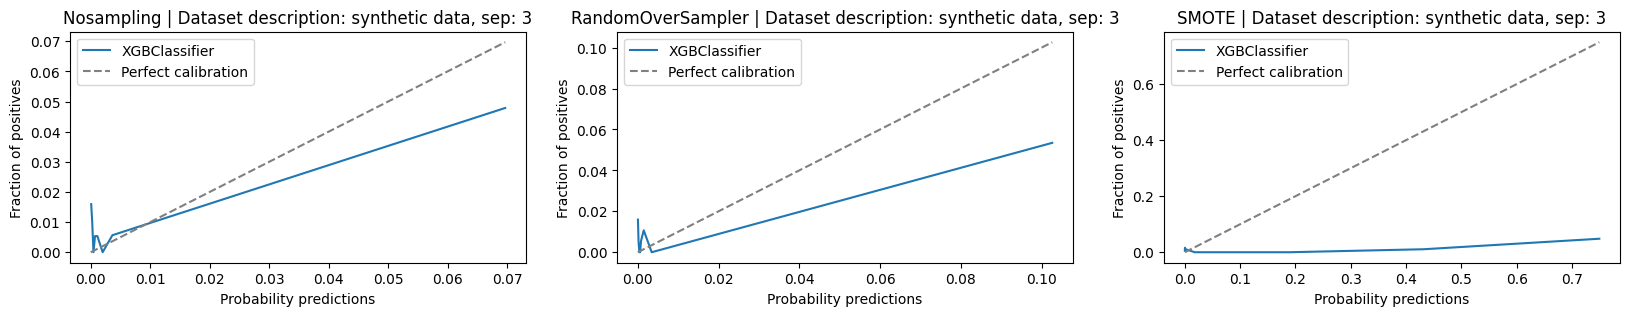

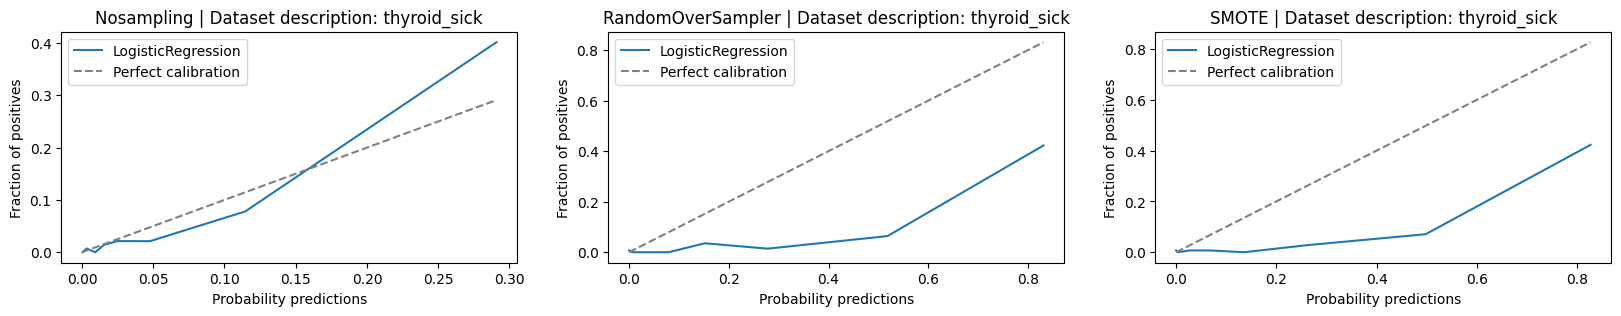

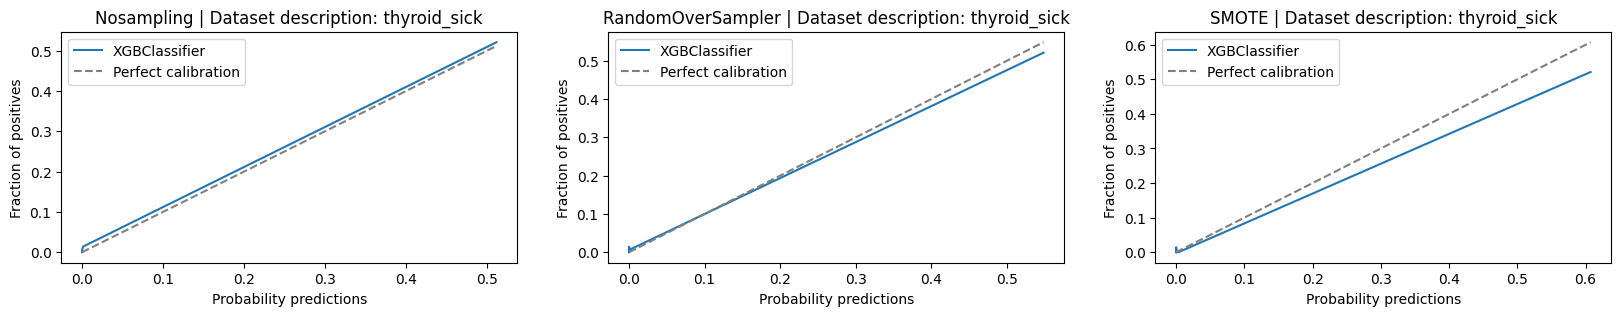

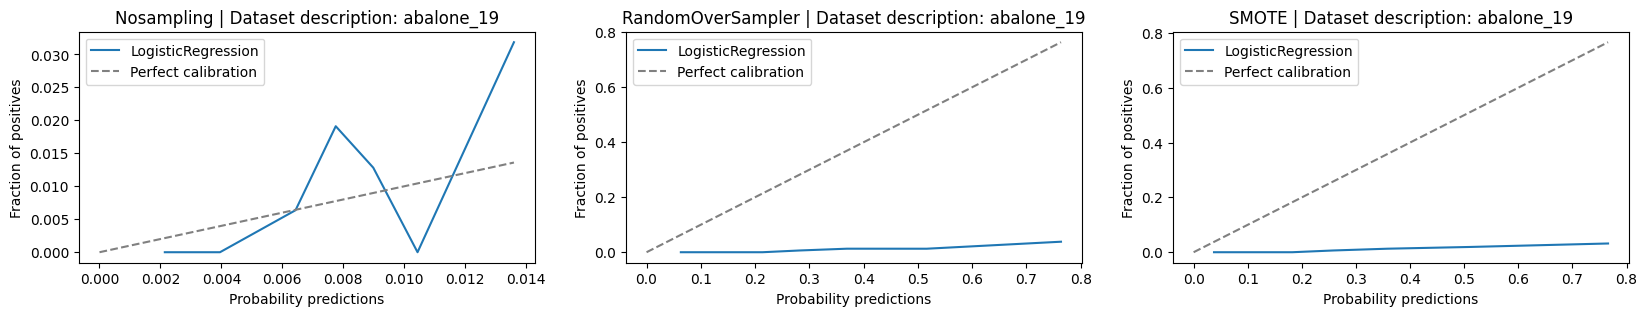

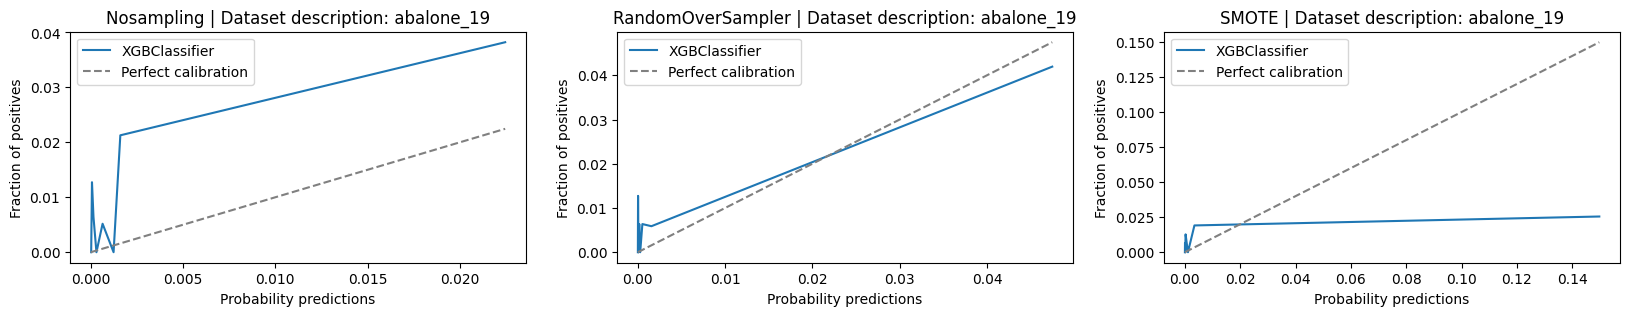

In [12]:
draw_plots(oversampler_map)

# Impact of undersampling techniques on calibration of a model

### Models used: LogisticRegression and XGBoost

In [13]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

undersampler_map = {
    "Nosampling": None,
    "RandomUnderSampler": RandomUnderSampler(
        sampling_strategy="auto", random_state=0, replacement=False
    ),
    "tomek": TomekLinks(sampling_strategy="auto", n_jobs=4),
}

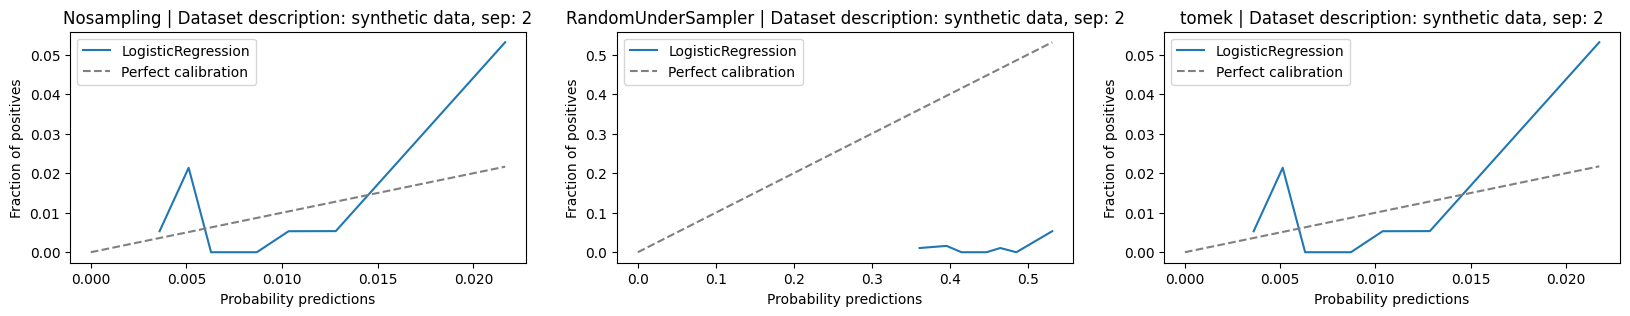

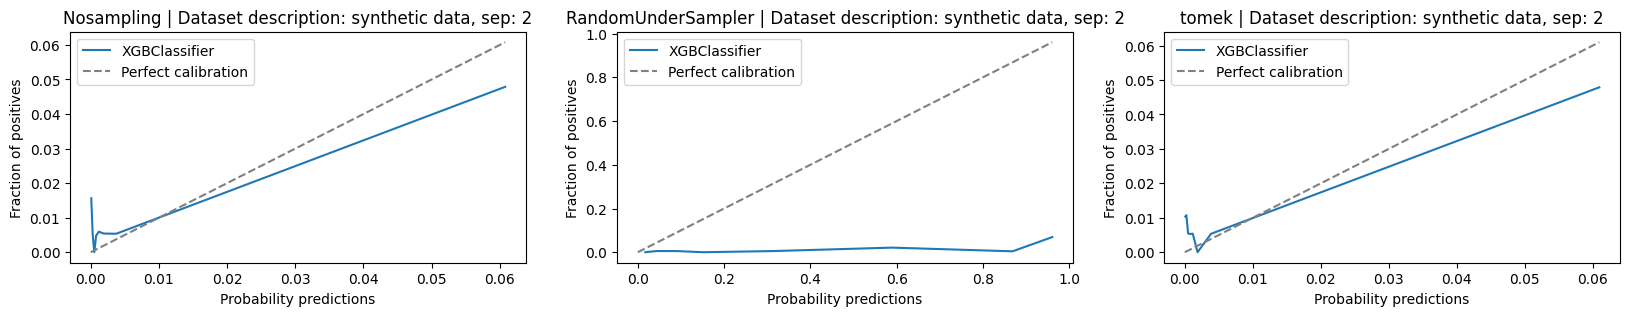

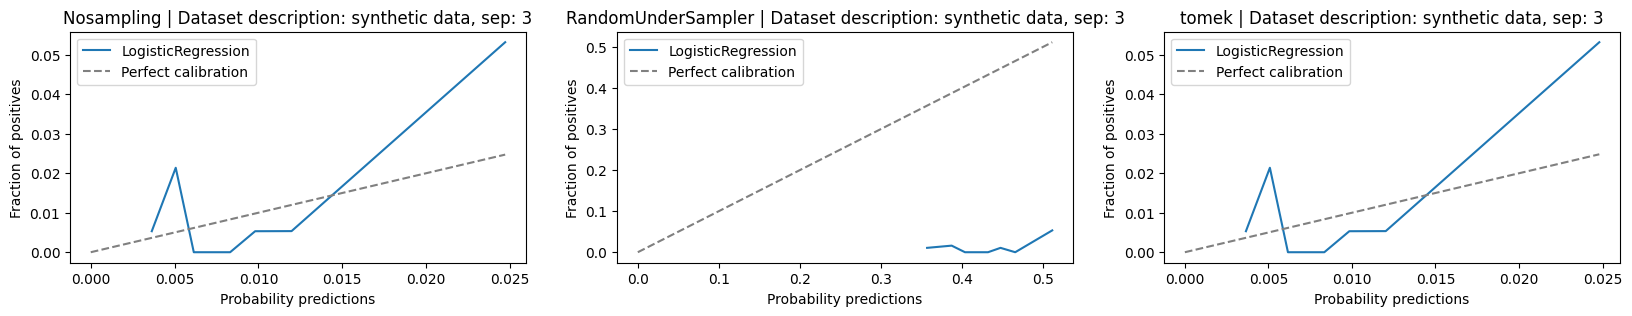

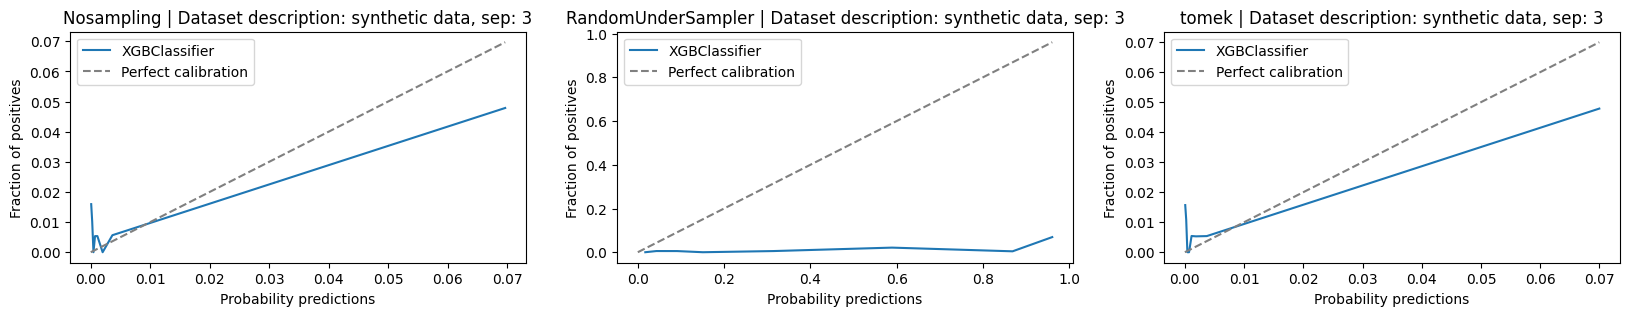

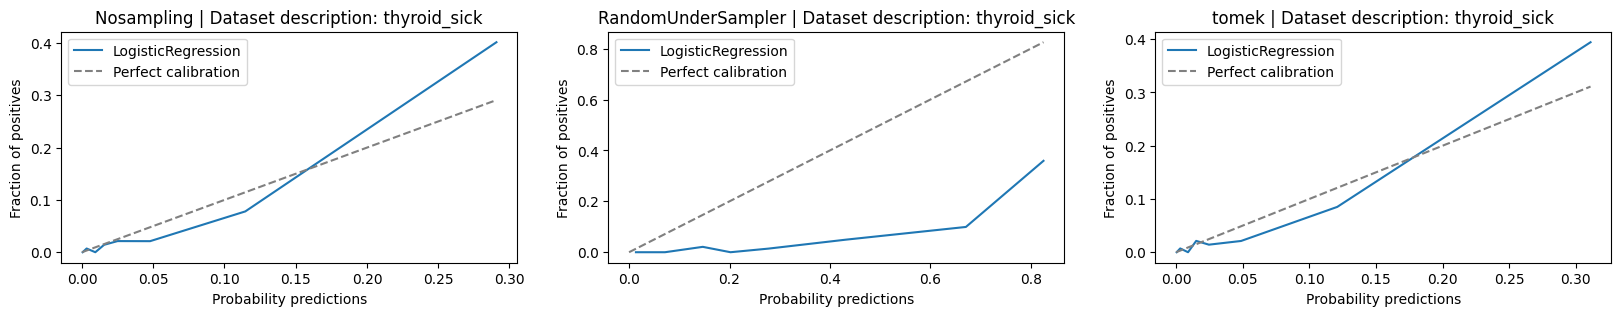

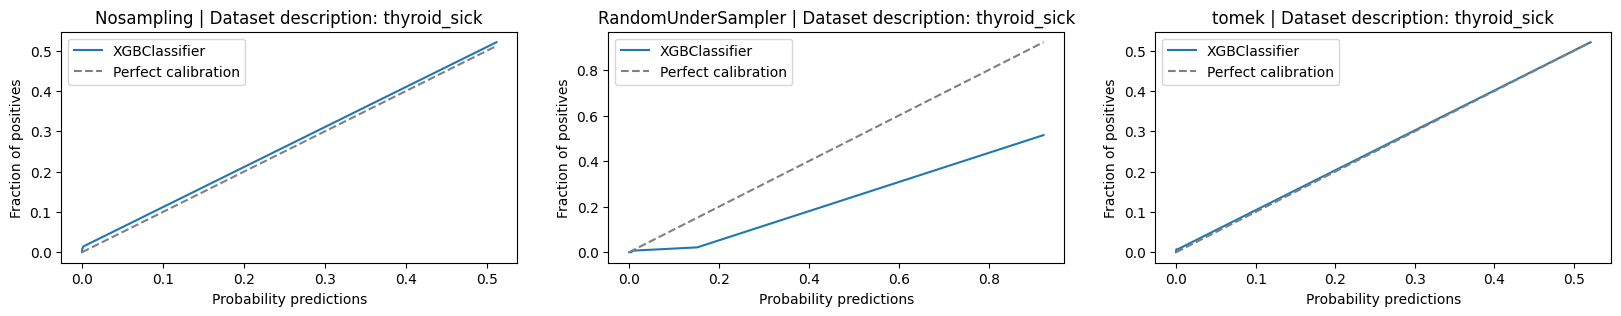

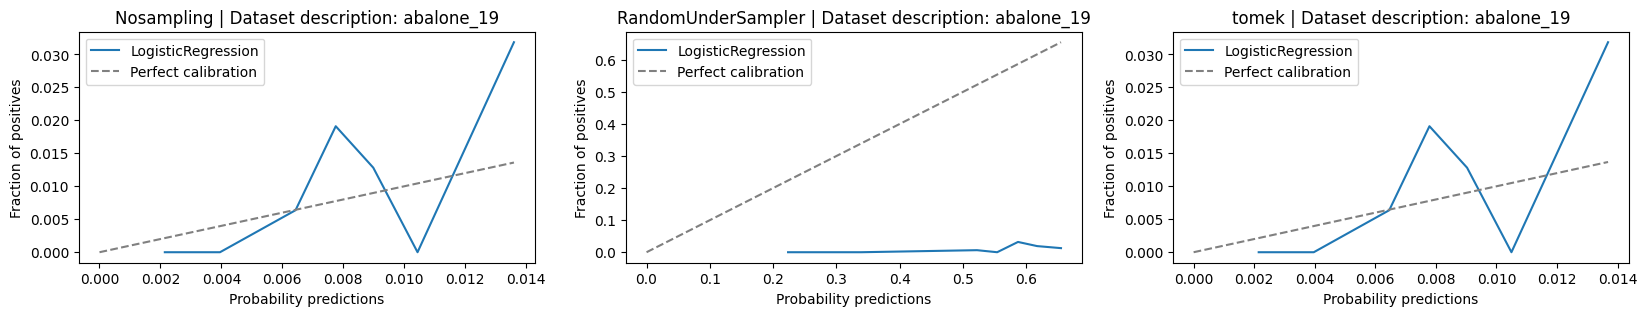

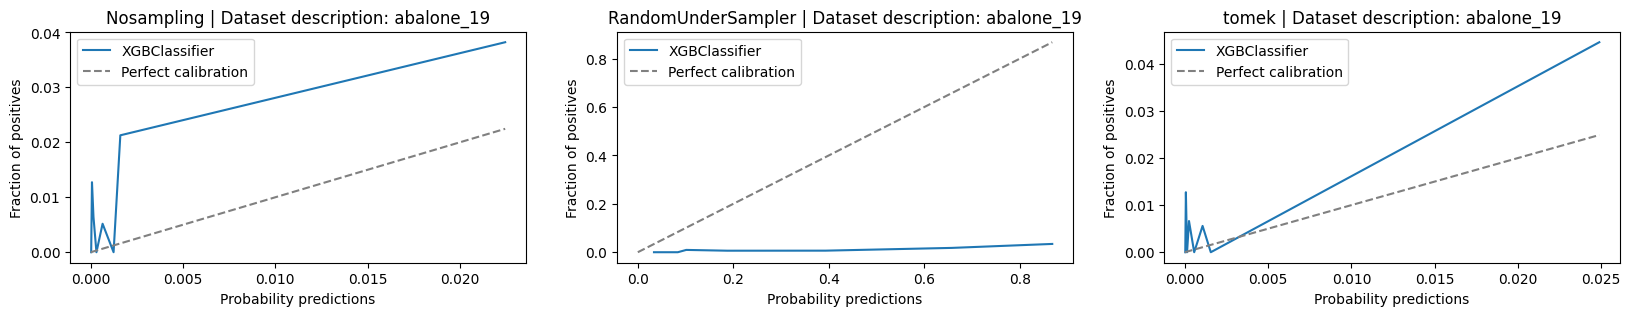

In [14]:
draw_plots(undersampler_map)

# Impact of cost-sensitive techniques on calibration of a model

### Models used: LogisticRegression and XGBoost

In [17]:
def find_ratio(y):
    return float(np.sum(y == 0)) / np.sum(y == 1)


def fit_model_call_plot_calibration_curve(
    data, model, X_train, X_test, y_train, y_test, axis
):
    run_details = "Dataset description: " + data["DESCR"]
    model = fit_model(model, X_train, y_train)
    model_probs = model.predict_proba(X_test)[:, 1]
    plot_calibration_curve(run_details, axis, y_test, model_probs, bins=8, model=model)


def draw_plots():
    for data in all_datasets:
        X_train, X_test, y_train, y_test = train_test_split(
            data["data"],
            data["target"],
            test_size=0.3,
            random_state=0,
        )

        # no class weighting used
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 2))
        lr = LogisticRegression(class_weight=None, random_state=0, max_iter=2000)
        fit_model_call_plot_calibration_curve(
            data, lr, X_train, X_test, y_train, y_test, axes[0]
        )
        # plt.show()

        # using class weighting
        lr = LogisticRegression(class_weight="balanced", random_state=0, max_iter=2000)
        fit_model_call_plot_calibration_curve(
            data, lr, X_train, X_test, y_train, y_test, axes[1]
        )
        # plt.show()

        # using no class weighting
        xgb = XGBClassifier()
        fit_model_call_plot_calibration_curve(
            data, xgb, X_train, X_test, y_train, y_test, axes[2]
        )

        # using class weighting
        xgbwt = XGBClassifier(scale_pos_weight=find_ratio(y_train))
        fit_model_call_plot_calibration_curve(
            data, xgbwt, X_train, X_test, y_train, y_test, axes[3]
        )

        plt.show()

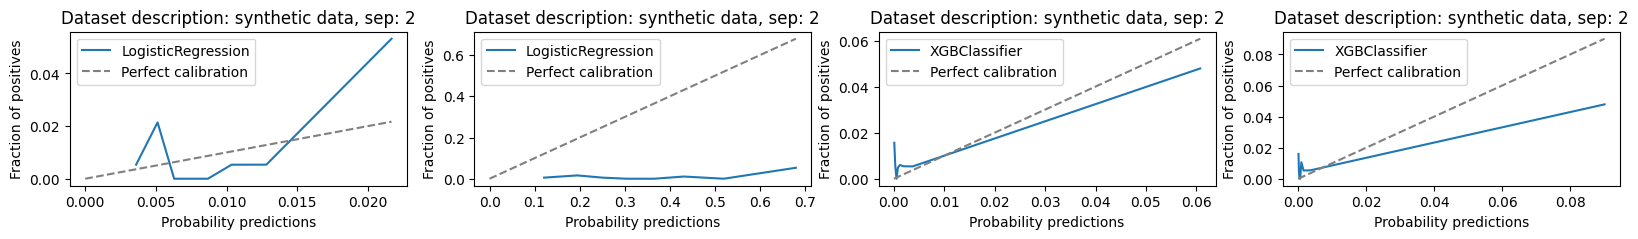

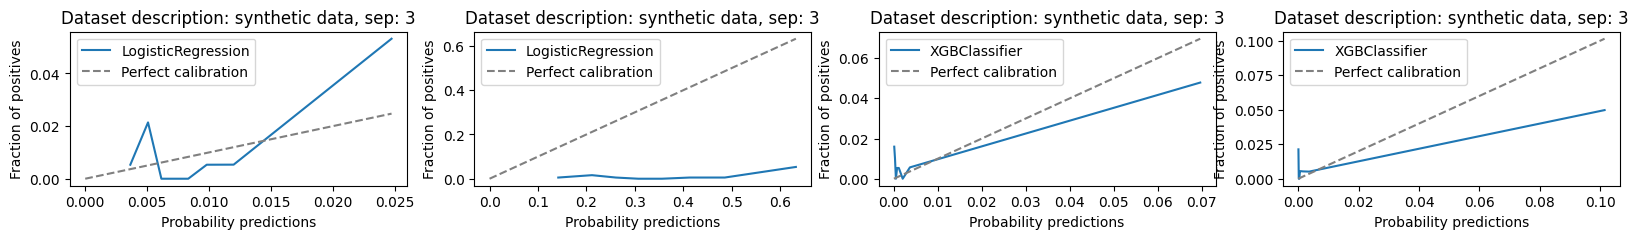

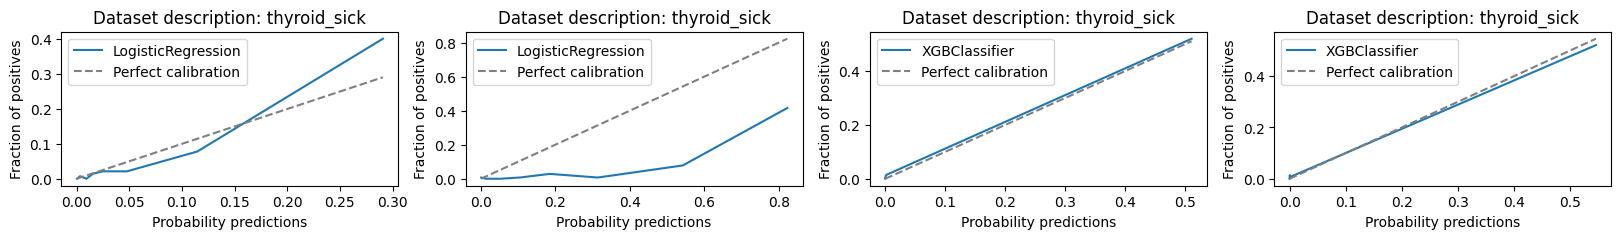

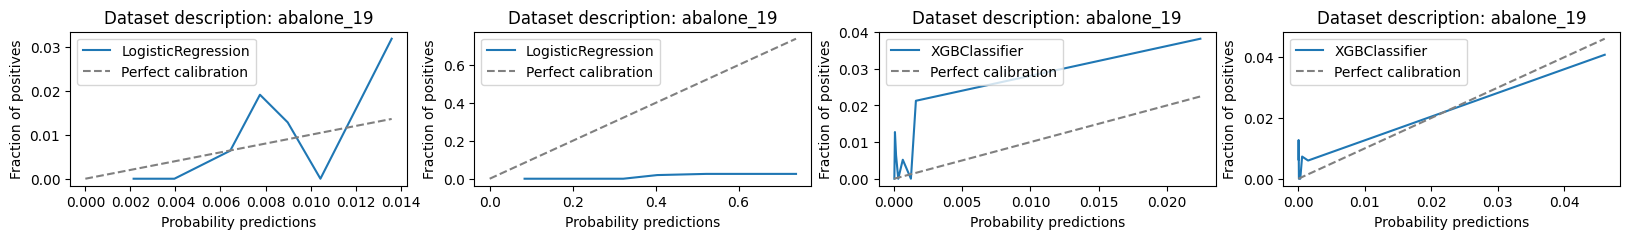

In [18]:
draw_plots()